## Computing the variance of the coefficients in the BFE:


### to-do:
- check where to multiply $m$ when computing $b$
- How to compare between smoothed coefficients and more energetic coefficients
- For computing orbits the best way will be to minimize the accelerations. However, for time -dependent analysis it is no clear yet if just cuts in energies will be good. 
- Compute $\Delta a$ with the smoothed coefficients and see how good it does. See to what energy levels cuts it corresponds to.


In [123]:
%pylab inline
import biff
from scipy import special
import pygadgetreader
import reading_snapshots
#import gala
from gadget_read_snap import read_snap

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [142]:
r_s_sims = 40.85
G_gadget=43007.1 #kpc3/(Gyr2Msun)/1E10. 

In [172]:
font = {'size':18, 'family':'serif'}
matplotlib.rc('font', **font)


In [194]:

def Anl(n, l):
    knl = 0.5*n*(n+4*l+3) + (l+1)*(2*l+1)
    A_nl = - 2**(8*l+6)/(4*np.pi*knl) * (special.factorial(n)*(n+2*l+3/2.)*(special.gamma(2*l+3/2.))**2)/(special.gamma(n+4*l+3))
    return A_nl


def smoothing(cov_matrix, coeff, m):
    """
    Coefficients smoothing 
    
    """
    var_coeff = (cov_matrix - coeff**2)#*m
    b_nlm = 1/(1 + var_coeff/coeff**2)
    # This line remove nans an put the original values
    b_nlm_values = np.nan_to_num(b_nlm)
    return b_nlm_values

In [4]:
data = loadtxt('./MW/MW_100M_b1_dm_part_1e5.txt')

In [5]:
posx = data[:,0]
posy = data[:,1]
posz = data[:,2]
mass = data[:,3]

In [6]:
pos = np.array([posx, posy, posz]).T

In [12]:
S_mwlmc, T_mwlmc = biff.compute_coeffs_discrete(np.double(pos), mass, 20, 20, 
                                                      skip_m=False, r_s=40.85, compute_var=True)

In [192]:
b_smooth_S = smoothing(S_mwlmc[1], S_mwlmc[0], mass[0])
b_smooth_T = smoothing(T_mwlmc[1], T_mwlmc[0], mass[0])

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [136]:
n_max = l_max = m_max = 21
A_nl_array = np.zeros((n_max, l_max))
for j in range(n_max):
    for i in range(l_max):
        A_nl_array[j][i] = Anl(j, i)
A_nl_matrix = np.zeros((n_max, l_max, m_max))
for i in range(m_max):
    A_nl_matrix[:,:,i] = A_nl_array

In [137]:
U = -0.5 * (S_mwlmc[0]**2 + T_mwlmc[0]**2)/A_nl_matrix

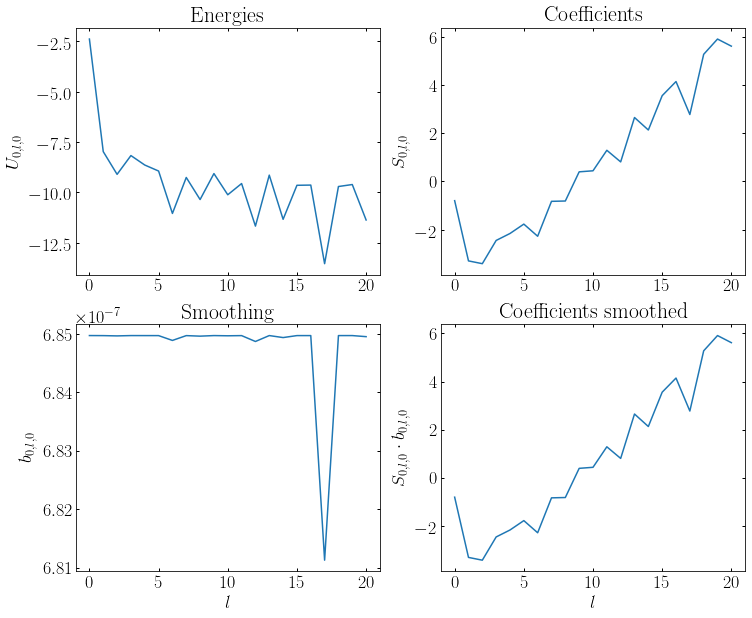

In [193]:
for i in range(1):
    figure(figsize=(12, 10))

    subplot(2, 2, 1)
    title('Energies')
    plot(np.log10(U[i,:,0]))
    legend()
    ylabel('$U_{0,l,0}$')

    subplot(2, 2, 2)
    title('Coefficients')
    plot(np.log10(np.abs(S_mwlmc[0][i,:,0])), label=r'$l=0')
    ylabel('$S_{0,l,0}$')


    subplot(2, 2, 3)
    title('Smoothing')
    plot(np.log10(b_smooth_S[i,:,0]), label=r'$l=0')
    xlabel('$l$')
    ylabel('$b_{0,l,0}$')


    subplot(2, 2, 4)
    title('Coefficients smoothed')
    plot(np.log10(b_smooth_S[i,:,0]*np.abs(S_mwlmc[0][i,:,0])), label=r'$l=0')
    ylabel('$S_{0,l,0}\cdot b_{0,l,0}$')
    xlabel('$l$')

    savefig('energies_smoothed_n_{}.pdf'.format(i))
    #close()

In [190]:
b_smooth_S[0,:,0]

array([  4.22918872e+10,   6.44587444e+05,   1.19044290e+05,
         1.90605408e+06,   1.03524803e+06,   7.64916103e+05,
         8.20934754e+03,   6.65212816e+05,   6.72419842e+04,
         1.62560310e+06,   1.75548724e+05,   7.57925194e+05,
         6.74648362e+03,   2.69378392e+06,   1.99158688e+04,
         1.10907021e+06,   1.29034810e+06,   1.77933661e+02,
         1.37887095e+06,   1.90497363e+06,   3.63759246e+04])

## $\Delta a$ with smoothed coeff

In [124]:
snap_gadget_1e6 = read_snap('./MW/gadget3_MW5_100M_b1_dmhalopart_elgato_1e6_001')

256
12000000 blocksize pp
4000000 blocksize ids
4000000 blocksize mass


In [125]:
acc_gadget_1e6 = snap_gadget_1e6[2]
pos_gadget_1e6 = snap_gadget_1e6[0]
pot_gadget_1e6 = snap_gadget_1e6[1]

In [140]:
N_rand_1e6 = np.random.randint(0, 1000000, 5000)

In [144]:
r_sims_1e6 = (pos_gadget_1e6[:,0]**2 + pos_gadget_1e6[:,1]**2 + pos_gadget_1e6[:,2]**2)**0.5


In [176]:
a_all = biff.gradient(np.ascontiguousarray(np.double(pos_gadget_1e6[N_rand_1e6])), 
                    S_mwlmc[0], T_mwlmc[0], G=G_gadget, M=1, r_s=r_s_sims)

a_smooth = biff.gradient(np.ascontiguousarray(np.double(pos_gadget_1e6[N_rand_1e6])), 
                    S_mwlmc[0]*b_smooth_S, T_mwlmc[0]*b_smooth_T, G=G_gadget, M=1, r_s=r_s_sims)



(0, 4)

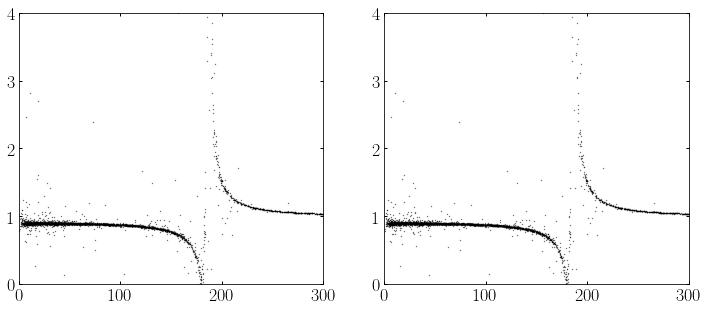

In [253]:
r_sort = argsort(r_sims_1e6[N_rand_1e6])
figure(figsize=(12, 5))
subplot(1, 2, 1)
scatter(r_sims_1e6[N_rand_1e6][r_sort], 
         np.abs(-a_all[r_sort,2]-acc_gadget_1e6[N_rand_1e6,2][r_sort])/np.abs(acc_gadget_1e6[N_rand_1e6,2][r_sort])
        ,  color='k', alpha=0.8, label='$10^{6}$', s=0.1)
xlim(0, 300)
ylim(0, 4)

subplot(1, 2, 2)
scatter(r_sims_1e6[N_rand_1e6][r_sort], 
         np.abs(-a_smooth[r_sort,2]-acc_gadget_1e6[N_rand_1e6,2][r_sort])/np.abs(acc_gadget_1e6[N_rand_1e6,2][r_sort])
        ,  color='k', alpha=0.8, label='$10^{6}$', s=0.1)

xlim(0, 300)
ylim(0, 4)

In [234]:
def a_r(r, a, bins, rmax):
    r_bin = np.linspace(min(r), rmax, bins)
    a_mean = np.zeros(bins)
    a_std = np.zeros(bins)
    for i in range(bins-1):
        dr = np.where((r>r_bin[i]) & (r<r_bin[i+1]))[0]
        a_mean[i] = np.nanmean(a[dr])
        a_std[i] = np.nanstd(a[dr])
    return r_bin, a_mean, a_std
        
        
    

In [248]:
rsmooth, a_smooth_mean, a_smooth_std = a_r(r_sort, np.abs(-a_smooth[:,0]-acc_gadget_1e6[N_rand_1e6,0])
                                           /np.abs(acc_gadget_1e6[N_rand_1e6,0]), 100, 300)

In [256]:
rsmooth, a_all_mean, a_all_std = a_r(r_sort, np.abs(-a_all[:,0]-acc_gadget_1e6[N_rand_1e6,0])
                                           /np.abs(acc_gadget_1e6[N_rand_1e6,0]), 100, 300)

(-1, 6)

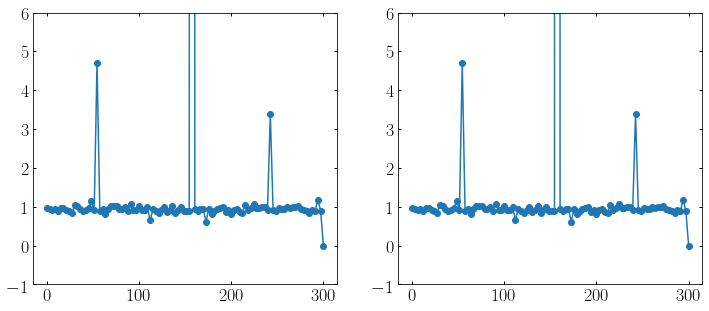

In [260]:
figure(figsize=(12, 5))
subplot(1, 2, 1)
plot(rsmooth, a_smooth_mean, '-o')
ylim(-1, 6)

subplot(1, 2, 2)
plot(rsmooth, a_all_mean, '-o')
ylim(-1, 6)
